In [29]:
import numpy as np
import pandas as pd

from theano import tensor

import fuel
import h5py
from fuel.datasets.hdf5 import H5PYDataset
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme
from fuel.transformers import Flatten

from blocks.bricks import Linear, Logistic, Softmax
from blocks.bricks.cost import CategoricalCrossEntropy
from blocks.roles import WEIGHT
from blocks.graph import ComputationGraph
from blocks.filter import VariableFilter
from blocks.initialization import IsotropicGaussian, Constant
from blocks.algorithms import GradientDescent, Scale, AdaGrad, Adam
from blocks.extensions.monitoring import DataStreamMonitoring
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing
from blocks.extensions.monitoring import TrainingDataMonitoring
from blocks_extras.extensions.plot import Plot

%matplotlib inline

In [30]:
header = ["label", "cap-shape","cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size", "gill-color",
"stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
"stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type", "spore-print-color", "population",
"habitat"]

def makeOneHot(col):
    vals,idx = pd.factorize(col)
    res = np.zeros((len(vals),len(idx)))
    res[range(len(vals)),vals] = 1
    return res

def loadData():
    df = pd.read_csv("./agaricus-lepiota.data", header=0, names=header)
    X = np.hstack([makeOneHot(df[c]) for c in header[1:]])
    y = makeOneHot(df[header[0]])
    
    return X, y

def randomizeData(X,y):
    num_instances = X.shape[0]
    indices = np.random.permutation(num_instances)
    return X[indices,:], y[indices]

X, y = loadData()
X, y = randomizeData(X,y)


print X.shape, y.shape

(8123, 117) (8123, 2)


In [31]:
def createH5Dataset(path,X,y):
    f = h5py.File(path, mode='w')

    split = int(8123*0.8)

    features = f.create_dataset('features', (8123, 117), dtype='uint8')
    targets = f.create_dataset('targets', (8123, 2), dtype='uint8')

    features[...] = X
    targets[...] = y

    split_dict = {
         'train': {'features': (0, splits), 'targets': (0, splits)},
         'test':  {'features': (split+1,8123), 'targets': (split,8123)},
    }
    f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

    f.flush()
    f.close()

#createH5Dataset("dataset.hdf5", X, y)

#train_data = H5PYDataset('dataset.hdf5', which_sets=('train',), load_in_memory=True)
#test_data  = H5PYDataset('dataset.hdf5', which_sets=('test',), load_in_memory=True)

In [32]:
from fuel.datasets import IndexableDataset

def createDataset(X,y):
    split = int(X.shape[0]*0.8)
    
    train = IndexableDataset({
        'features': X[:split,:].astype(np.uint8),
        'targets': y[:split].astype(np.uint8)
    })
    test  = IndexableDataset({
        'features': X[split:,:].astype(np.uint8),
        'targets': y[split:].astype(np.uint8)
    })
    
    return train, test

train_data, test_data = createDataset(X, y)

In [33]:
data_stream = Flatten(DataStream.default_stream(
     train_data,
     iteration_scheme=SequentialScheme(train_data.num_examples, batch_size=50)))

data_stream_test = Flatten(DataStream.default_stream(
        test_data, 
        iteration_scheme=SequentialScheme(
        test_data.num_examples, batch_size=1000)))

In [41]:
from blocks.bricks.cost import MisclassificationRate

def makeGraph():
    Xs = tensor.matrix("features")
    y = tensor.lmatrix('targets')
    
    h1 = Linear(name='h1', input_dim=117, output_dim=70)
    a1 = Logistic().apply(h1.apply(Xs))
    h2 = Linear(name='h2', input_dim=70, output_dim=2)
    y_hat = Softmax().apply(h2.apply(a1))
    
    h1.weights_init = h2.weights_init = IsotropicGaussian(0.01)
    h1.biases_init = h2.biases_init = Constant(0)
    h1.initialize()
    h2.initialize()
    
    cost = CategoricalCrossEntropy().apply(y, y_hat)
    
    cg = ComputationGraph(cost)
    W1, W2 = VariableFilter(roles=[WEIGHT])(cg.variables)
    
    cost = cost + 0.005 * (W1 ** 2).sum() + 0.005 * (W2 ** 2).sum()
    cost.name = 'cost_with_regularization'
    
    mcr = MisclassificationRate().apply(y.argmax(axis=1), y_hat)
    mcr.name = "misclassification rate"
    
    return cg,(W1,W2),cost,mcr

In [42]:
cg, (W1,W2), cost, mcr = makeGraph()

main_loop = MainLoop(data_stream = data_stream, 
                     algorithm   = GradientDescent(
                                    cost=cost, 
                                    parameters=cg.parameters,
                                    step_rule=Scale(learning_rate=0.1)),
                      extensions = [
                        DataStreamMonitoring(variables=[cost, mcr], data_stream=data_stream_test), 
                        FinishAfter(after_n_epochs=10), 
                        Printing(),
                        #TrainingDataMonitoring([cost,], after_batch=True),
                      ]
)
main_loop.run() 


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 cost_with_regularization: 0.69959283783
	 misclassification rate: 0.515


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 130:
	 cost_with_regularization: 0.620252515407
	 miscl

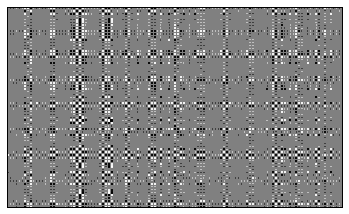

In [44]:
import matplotlib.pyplot as plt


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
#print W1.get_value()
hinton(W1.get_value())
plt.show()
hinton(W2.get_value())
plt.show()

In [47]:
cg, (W1,W2), cost, mcr = makeGraph()
main_loop = MainLoop(data_stream = data_stream, 
                     algorithm   = GradientDescent(
                                        cost=cost, 
                                        parameters=cg.parameters,
                                        step_rule=AdaGrad()),
                    extensions = [
                        DataStreamMonitoring(variables=[cost, mcr], data_stream=data_stream_test), 
                        FinishAfter(after_n_epochs=20), 
                        Printing(),
                        #TrainingDataMonitoring([cost,], after_batch=True),
                      ]
)
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 cost_with_regularization: 0.702552455124
	 misclassification rate: 0.515


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 130:
	 cost_with_regularization: 0.640689906044
	 misc

In [48]:
cg, (W1,W2), cost, mcr = makeGraph()
main_loop = MainLoop(data_stream = data_stream, 
                     algorithm   = GradientDescent(
                                        cost=cost, 
                                        parameters=cg.parameters,
                                        step_rule=Adam()),
                      extensions = [
                        DataStreamMonitoring(variables=[cost, mcr], data_stream=data_stream_test), 
                        FinishAfter(after_n_epochs=20), 
                        Printing(),
                        #TrainingDataMonitoring([cost,], after_batch=True),
                      ]
)
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 cost_with_regularization: 0.6988425957
	 misclassification rate: 0.515


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 130:
	 cost_with_regularization: 0.262812283985
	 miscla